In [ ]:
import pandas as pd
df = pd.read_csv('data/data.csv')
# df = df.sample(frac=0.001, random_state=42)
# df = df.sample(n=2000, random_state=42)
print(df.info())
print(df[df['content'].isnull()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31436 non-null  object
 1   label    31460 non-null  object
 2   start    31460 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 737.5+ KB
None
      content label  start
1462      NaN   POS      5
1931      NaN   NEG      2
3730      NaN   NEU      3
8194      NaN   NEG      1
8355      NaN   POS      4
10181     NaN   POS      5
17982     NaN   POS      5
20142     NaN   NEU      3
22059     NaN   POS      5
23510     NaN   NEU      3
25543     NaN   POS      4
25703     NaN   POS      5
27954     NaN   NEG      2
28009     NaN   POS      4
28402     NaN   NEG      2
28741     NaN   NEU      3
29145     NaN   POS      5
29231     NaN   POS      5
29509     NaN   POS      5
30010     NaN   POS      5
30154     NaN   POS      5
30907     NaN   POS      5
30992     NaN   NEG      1
31

In [ ]:
df = df.dropna(subset=['content'])
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31436 entries, 0 to 31435
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31436 non-null  object
 1   label    31436 non-null  object
 2   start    31436 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 736.9+ KB
None


In [ ]:
from underthesea import word_tokenize
df["content_segmented"] = df["content"].apply(lambda x: word_tokenize(x, format="text"))
print(df.head())

/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                      content label  start             content_segmented
0               Áo bao đẹp ạ!   POS      5                Áo bao đẹp ạ !
1                   Tuyệt vời   POS      5                     Tuyệt_vời
2   2day ao khong giong trong   NEG      1    2 day ao khong_giong trong
3  Mùi thơm,bôi lên da mềm da   POS      5  Mùi thơm , bôi lên da mềm da
4            Vải đẹp, dày dặn   POS      5             Vải đẹp , dày dặn


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

x_train = train_df["content"].tolist()
x_test = test_df["content"].tolist()

x_train_segmented = train_df["content_segmented"].tolist()
x_test_segmented = test_df["content_segmented"].tolist()

y_train = train_df["label"].tolist()
y_test = test_df["label"].tolist()



In [ ]:
from sklearn.naive_bayes import MultinomialNB

tmp = TfidfVectorizer(ngram_range=(1,2))
preproc   = tmp.build_preprocessor() 
tokenizer = tmp.build_tokenizer()   

vec = TfidfVectorizer(
    preprocessor=preproc,
    tokenizer=tokenizer,
    token_pattern=None,
    ngram_range=(1,2),
    min_df=2
)

pipe = Pipeline([
    ('tfidf', vec),
    ('nb',   MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha':          [0.1, 0.5, 1.0],
    'nb__fit_prior':      [True, False]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)

gs.fit(x_train_segmented, y_train)
print("Best hyper-parameters:", gs.best_params_)

y_pred_nb = gs.predict(x_test_segmented)
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))

Best hyper-parameters: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tfidf__ngram_range': (1, 2)}
=== Naive Bayes ===
              precision    recall  f1-score   support

         NEG       0.68      0.76      0.72      1353
         NEU       0.45      0.17      0.24       987
         POS       0.83      0.92      0.87      3948

    accuracy                           0.77      6288
   macro avg       0.65      0.62      0.61      6288
weighted avg       0.74      0.77      0.74      6288



In [ ]:
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
)

pipe_svm = Pipeline([
    ("tfidf", tfidf),
    ("svm",   LinearSVC(max_iter=10000))
])

param_grid_svm = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "svm__C":            [0.1, 1, 10],
    "svm__class_weight": [None, "balanced"]
}

gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_svm.fit(x_train_segmented, y_train)

print("Best hyper-parameters (SVM):", gs_svm.best_params_)

y_pred_svm = gs_svm.predict(x_test_segmented)
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyper-parameters (SVM): {'svm__C': 0.1, 'svm__class_weight': None, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

         NEG       0.69      0.76      0.73      1353
         NEU       0.54      0.14      0.22       987
         POS       0.82      0.95      0.88      3948

    accuracy                           0.78      6288
   macro avg       0.68      0.61      0.61      6288
weighted avg       0.75      0.78      0.74      6288



In [ ]:
import os
from datasets import Dataset
from transformers import AutoTokenizer
import py_vncorenlp
import evaluate

label2id = {"NEG": 0, "NEU": 1, "POS": 2}
train_labels = [label2id[label] for label in y_train]
test_labels  = [label2id[label] for label in y_test]

save_directory = os.path.join(os.getcwd(), 'vncorenlp') 
py_vncorenlp.download_model(save_dir=save_directory)
rdrsegmenter = py_vncorenlp.VnCoreNLP(save_dir=save_directory)

def word_segment(sent):
    return ' '.join(rdrsegmenter.word_segment(sent))

x_train_seg = [word_segment(s) for s in x_train]
x_test_seg  = [word_segment(s) for s in x_test]

train_ds = Dataset.from_dict({"text": x_train_seg, "label": train_labels})
test_ds  = Dataset.from_dict({"text": x_test_seg,  "label": test_labels})

MODEL_v2 = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_v2)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn,  batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch",  columns=cols)


VnCoreNLP model folder /Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/vncorenlp already exists! Please load VnCoreNLP from this folder!
2025-06-21 16:31:54 INFO  WordSegmenter:24 - Loading Word Segmentation model
2025-06-21 16:31:54 INFO  PosTagger:23 - Loading POS Tagging model
2025-06-21 16:31:56 INFO  NerRecognizer:34 - Loading NER model
2025-06-21 16:32:04 INFO  DependencyParser:32 - Loading Dependency Parsing model


Map: 100%|██████████| 6288/6288 [00:00<00:00, 11515.76 examples/s]


In [ ]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(MODEL_v2, num_labels=3)

accuracy  = evaluate.load("accuracy")
f1        = evaluate.load("f1")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro":  f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall":    recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    }

training_args = TrainingArguments(
    output_dir="./phobert_sentiment",
    num_train_epochs=2,
    per_device_train_batch_size=4,      
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_steps=5000,
    save_total_limit=1,
    do_train=True,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.760600
400,0.606100
600,0.595100
800,0.591100
1000,0.587700
1200,0.631500
1400,0.653800
1600,0.551100
1800,0.593000
2000,0.571500


/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6144339442253113, 'eval_accuracy': 0.8088422391857506, 'eval_f1_macro': 0.6870689895752973, 'eval_precision': 0.7023134826459246, 'eval_recall': 0.6827351279868146, 'eval_runtime': 74.9912, 'eval_samples_per_second': 83.85, 'eval_steps_per_second': 10.481, 'epoch': 2.0}


/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_87610/3406889273.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


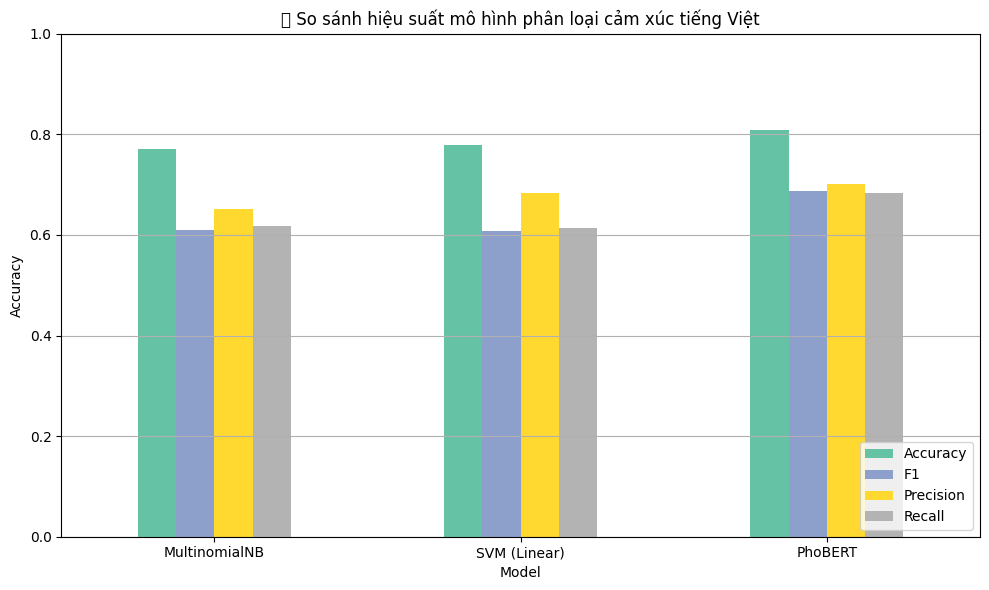

/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_87610/3406889273.py:71: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/.pyenv/versions/3.9.21/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


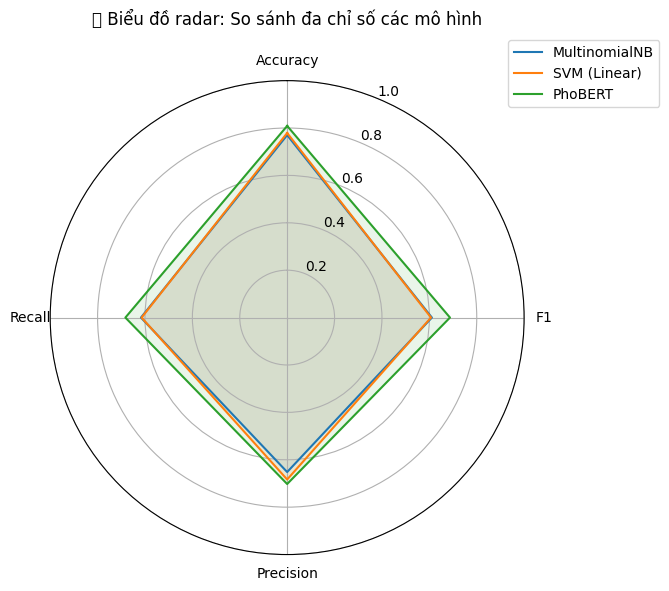

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

nb_metrics = {
    'Model': 'MultinomialNB',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1': f1_score(y_test, y_pred_nb, average='macro'),
    'Precision': precision_score(y_test, y_pred_nb, average='macro'),
    'Recall': recall_score(y_test, y_pred_nb, average='macro'),
}

svm_metrics = {
    'Model': 'SVM (Linear)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1': f1_score(y_test, y_pred_svm, average='macro'),
    'Precision': precision_score(y_test, y_pred_svm, average='macro'),
    'Recall': recall_score(y_test, y_pred_svm, average='macro'),
}

phobert_metrics = {
    "Model": "PhoBERT",
    "Accuracy": metrics["eval_accuracy"],
    "F1":       metrics["eval_f1_macro"],
    "Precision": metrics["eval_precision"],
    "Recall":    metrics["eval_recall"]
}

df = pd.DataFrame([nb_metrics, svm_metrics, phobert_metrics])
df.set_index("Model", inplace=True)
df = df.dropna(axis=1)  

df.plot(kind="bar", figsize=(10, 6), colormap="Set2", rot=0)
plt.title("📊 So sánh hiệu suất mô hình phân loại cảm xúc tiếng Việt")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

labels = df.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for model_name, row in df.iterrows():
    values = row.tolist()
    values += values[:1] 
    ax.plot(angles, values, label=model_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1.0)

plt.title("🌐 Biểu đồ radar: So sánh đa chỉ số các mô hình", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
